In [1]:
import pickle
import numpy as np
import pandas as pd
import time

from matplotlib import pyplot as plt
from functions import get_X, get_y, question_from_v, data_without_v, get_movies_scores, remove_empty_variables
from metrics import random_forest, forward_feature_selection, backward_feature_elimination, random_variable_choice, variable_mean_choice
from variable_selection_metrics import user_questions, random_questions, loop_simulation, metrics_simulations

In [2]:
%load_ext autoreload
%autoreload 2

In [143]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load data

In [116]:
pkl = open('experiment_clean_lastfm.pkl','rb')
experiment_df = pickle.load(pkl)
pkl.close()

In [117]:
df = experiment_df.copy()

In [118]:
for c in get_X(experiment_df):
    df[c][df[c] >= 1] = 1

C:\Users\Visiteur\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [120]:
df.columns.size

229

# Optimization

In [6]:
metric_list = [random_variable_choice]  #[random_forest, forward_feature_selection, random_variable_choice, variable_mean_choice]
metric_names = ["VMC"] #["RF", "FFS", "RVC", "VMC"]

loopsize = 1

In [7]:
results, times, question_counts = metrics_simulations(df, metric_list, metric_names, loopsize, display = True)

 ========== VMC ========== 
k = 0


In [8]:
np.mean(df[73])

0.5299136092379947

In [9]:
selected_tags[selected_tags.tagID == 73]

NameError: name 'selected_tags' is not defined

# Creating a tree for the random forest choice

- Issue n°1 : a tree on 73 tags will have around 10^22 nodes
- Actually, the tree is not that deep -> Computation
- Pre-creating a part of the tree can be a good start : the longest computations are the first (always the same)

In term of area, only answering yes would bring to a depth of around 15 questions. Imagining the tree like a triangle would mean that the tree has a shape of 15 * 73 = 1095. Let's try it.

In [10]:
15 * 73

1095

In [62]:
user_result = user_questions(df, random_forest)

364? (y/n)n
194? (y/n)n
79? (y/n)y
46? (y/n)y
76? (y/n)y


Fonctions :
- Calcul d'une BDD après application d'une variable (data_without_v)
- Calcul d'une BDD après application d'une séquence de variables
- Application d'une séquence de question à une BDD, True si termine False sinon.

In [11]:
from functions import data_without_v

In [12]:
def data_without_sequence(data, sequence):
    """ By default, the threshold of variables are their mean on the initial database """
    new_data = data.copy()
    for (v, b) in sequence:
        X = get_X(new_data)
        avg = np.mean(X[v])
        new_data = data_without_v(new_data, v, avg, lower=(not b))
    return new_data

In [13]:
l = [(73, True), (79, True)]

In [14]:
data_without_sequence(df, l).shape

(35845, 13)

In [15]:
def ask_question_sequence(data, sequence):
    new_data = data_without_sequence(data, sequence)
    return new_data.item.unique().size <= 10

In [16]:
l = [(356, True), (275, True)]

In [121]:
ask_question_sequence(df, l)

In [112]:
df.columns.size

15

In [122]:
import copy

In [123]:
class Tree:
    def __init__(self, v):
        self.v = v
        self.left = None
        self.right = None
    
    def set_left(self, t):
        self.left = t

    def set_right(self, l):
        self.right = l
    
    def copy(self):
        if self.v == -1:
            return Tree(-1)
        else:
            t = Tree(self.v)
            if self.left != None:
                t.set_left(self.left.copy())
            if self.right != None:
                t.set_right(self.right.copy())
            return t

- Fonction supérieure ( BDD, metric )
- Sequence = []
- Fonction récursive ( sequence ) :
    - BDD_ = compute_sequence
    - if que_sequ(BDD_) ne donne pas de solution :
        - v = metric(BDD_)
        - sequence1 = sequence + [v:T]
        - sequence2 = sequence + [v:F]
        - Tree = Tree(v)
        - Tree.left = aux(sequence1)
        - Tree.right = aux(sequence2)
        - Return tree

In [124]:
def pre_compute_tree(data, metric, depth = 5):
    def rec(s):
        new_data = data_without_sequence(data, s)
        if len(s) > depth:
            return Tree(-1)
        if new_data.item.unique().size > 10 and len(get_X(new_data).columns) > 1:
            X, y = get_X(new_data), get_y(new_data)
            v = metric(X, y, display=False)
            
            s1 = s + [(v, True)]
            s2 = s + [(v, False)]
            print(s)
            
            t = Tree(v)
            t.set_left(rec(s1))
            t.set_left(rec(s2))
            
            return t
        return Tree(-1)
    return rec([])

In [125]:
t0 = time.time()
t5 = pre_compute_tree(df, random_forest, depth = 5)
time_t5 = time.time() - t0

[]
[(364, True)]
[(364, True), (347, True)]
[(364, True), (347, True), (287, False)]
[(364, True), (347, False)]
[(364, True), (347, False), (662, True)]
[(364, True), (347, False), (662, True), (781, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False)]
[(364, True), (347, False), (662, False)]
[(364, True), (347, False), (662, False), (1249, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, True)]
[(364, True), (347, False), (662, False), (1249, False), (208, False)]
[(364, False)]
[(364, False), (194, True)]
[(364, False), (194, True), (206, False)]
[(364, False), (194, True), (206, False), (385, True)]
[(364, False), (194, True), (206, False), (385, False)]
[(364, False), (194, True), (206, False), (385, False), (127, True)]
[(364, False), (194, True), (206, False), (385, False), (127, False)]
[(364, False), (194, False)]
[(364, False), (194, False), (79, True)]
[(364, False), (194, False), (79, True), (46, True)]
[(364, False), (194, Fal

# C'est quand même un peu long

-> Pré-créer la base de l'arbre (les premiers noeuds) puis laisse faire le reste par les algos.

In [93]:
t.v

73

- Faire une fonction qui calcul à partir d'un arbre
- Faire tourner des rf dessus avec des arbres de prof différentes
- Calculer les temps de calculs des arbres en fonction de leurs profondeurs
- Faire les calculs d'efficacité et de spread pour des bases plus grandes

In [126]:
def random_questions(data, metric, display = False, tree = None):
    new_data = data.copy()
    question_count = 0
    t = Tree(-1)
    if tree != None:
        t = tree.copy()
    
    while new_data.item.unique().size > 10 and len(get_X(new_data).columns) > 1:
        
        
        X, y = get_X(new_data), get_y(new_data)
        if t != None and t.v != -1:
            v = t.v
        else:
            v = metric(X, y, display=display)
        
        avg = np.mean(X[v])
        
        lower = True
        middle = (avg) / (0.0001 + np.max(new_data[v]) - np.min(new_data[v]))
        if np.random.rand() < middle:
            lower = False
        new_data = data_without_v(new_data, v, avg, lower=lower)
        if t != None and t.v != -1:
            if lower:
                t = t.left
            else:
                t = t.right
        
        if display:
            print(v)
            print(avg)
            print(lower)
            print(new_data.item.unique().size)
        
        question_count += 1
        
    return new_data, question_count

In [127]:
random_questions(df, random_forest, display = False, tree = t5)

(       item  user  rating  1  2  4  5  6  7  13  ...  1492  1534  1627  1753  \
 257     291     7       5  0  0  0  0  0  0   0  ...     0     0     0     0   
 299     333     7       0  1  0  0  0  0  0   0  ...     0     0     0     1   
 308     291     8       0  0  0  0  0  0  0   0  ...     0     0     0     0   
 506     333    12       5  1  0  0  0  0  0   0  ...     0     0     0     1   
 525     498    12       5  0  0  0  0  0  0   0  ...     0     0     0     1   
 ...     ...   ...     ... .. .. .. .. .. ..  ..  ...   ...   ...   ...   ...   
 91960  1201  2079       0  0  0  0  0  0  0   0  ...     0     0     0     1   
 92244   291  2087       0  0  0  0  0  0  0   0  ...     0     0     0     0   
 92256   333  2087       0  1  0  0  0  0  0   0  ...     0     0     0     1   
 92264   498  2087       0  0  0  0  0  0  0   0  ...     0     0     0     1   
 92536   291  2094       5  0  0  0  0  0  0   0  ...     0     0     0     0   
 
        1754  1911  1995  

In [128]:
tree5_times = []
for k in range(50):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t5)
    tree5_times.append(time.time() - t0)
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [130]:
notree_times = []
for k in range(20):
    t0 = time.time()
    random_questions(df, random_forest, display = False)
    notree_times.append(time.time() - t0)
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [131]:
t0 = time.time()
t10 = pre_compute_tree(df, random_forest, depth = 10)
time_t10 = time.time() - t0

[]
[(364, True)]
[(364, True), (347, True)]
[(364, True), (347, True), (287, False)]
[(364, True), (347, False)]
[(364, True), (347, False), (662, True)]
[(364, True), (347, False), (662, True), (781, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False), (85, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False), (85, False), (304, False)]
[(364, True), (347, False), (662, False)]
[(364, True), (347, False), (662, False), (1249, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, True)]
[(364, True), (347, False), (662, False), (1249, False), (208, False)]
[(364, True), (347, False), (662, False), (1249, False), (208

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, True), (170, False), (200, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, True)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, True), (84, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, True)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False)]
[(364, False), (194, False), (79, False)]
[(364, False), (194, False), (79, False), (127

In [132]:
tree10_times = []
for k in range(50):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t10)
    tree10_times.append(time.time() - t0)
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [133]:
print(np.mean(notree_times))
print(np.mean(tree5_times))
print(np.mean(tree10_times))

44.62266552448273
30.245958533287048
20.379229760169984


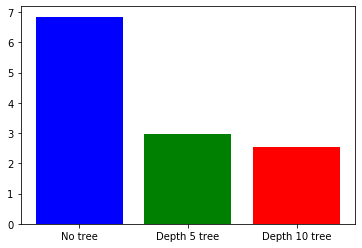

In [104]:
plt.bar(["No tree", "Depth 5 tree", "Depth 10 tree"], [np.mean(notree_times), np.mean(tree5_times), np.mean(tree10_times)], color = ['b','g','r','y'])

plt.show()

In [134]:
t0 = time.time()
t15 = pre_compute_tree(df, random_forest, depth = 15)
time_t15 = time.time() - t0

[]
[(364, True)]
[(364, True), (347, True)]
[(364, True), (347, True), (287, False)]
[(364, True), (347, False)]
[(364, True), (347, False), (662, True)]
[(364, True), (347, False), (662, True), (781, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False), (85, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False), (85, False), (304, False)]
[(364, True), (347, False), (662, False)]
[(364, True), (347, False), (662, False), (1249, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, True)]
[(364, True), (347, False), (662, False), (1249, False), (208, False)]
[(364, True), (347, False), (662, False), (1249, False), (208

[(364, False), (194, True), (206, False), (385, False), (127, False), (178, True), (741, False), (78, False), (186, False), (18, False), (210, False), (234, False), (432, False), (181, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, True), (741, False), (78, False), (186, False), (18, False), (210, False), (234, False), (432, False), (181, False), (79, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, True)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, True), (73, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, True), (73, False), (18, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180,

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False), (512, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False), (512, False), (662, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False), (512, False), (662, False), (850, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False), (512, False), (662, False), (850, False), (216, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False)]
[(3

[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, True), (1358, False), (617, False)]
[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, True), (1358, False), (617, False), (200, False)]
[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, True), (1358, False), (617, False), (200, False), (75, False)]
[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, True), (1358, False), (617, False), (200, False), (75, False), (2726, False)]
[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, True), (1358, False), (617, False), (200, False), (75, False), (2726, False), (167, False)]
[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, True), (1358, False), (617, False), (200, False), (75, False), (2726, False), (167, False), (84, False)]
[(364, False), (194, False), (79, Fa

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, True), (18, False), (735, False), (89, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, True), (18, False), (735, False), (89, False), (406, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, True), (18, False), (735, False), (89, False), (406, False), (2139, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, True), (18, False), (735, False), (89, False), (406, False), (2139, False), (5, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, False), (76, False)]
[(364, Fa

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, True), (103, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, True), (103, False), (724, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), 

In [135]:
tree15_times = []
for k in range(50):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t15)
    tree15_times.append(time.time() - t0)
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


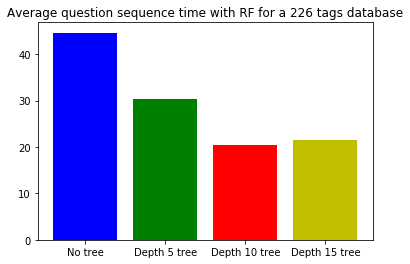

In [138]:
plt.bar(["No tree", "Depth 5 tree", "Depth 10 tree", "Depth 15 tree"], [np.mean(notree_times), np.mean(tree5_times), np.mean(tree10_times), np.mean(tree15_times)], color = ['b','g','r','y'])
plt.title("Average question sequence time with RF for a 226 tags database")
plt.show()

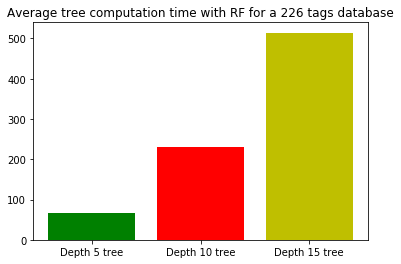

In [139]:
plt.bar(["Depth 5 tree", "Depth 10 tree", "Depth 15 tree"], [time_t5, time_t10, time_t15], color = ['g','r','y'])
plt.title("Average tree computation time with RF for a 226 tags database")
plt.show()

In [140]:
t0 = time.time()
t20 = pre_compute_tree(df, random_forest, depth = 20)
time_t20 = time.time() - t0

[]
[(364, True)]
[(364, True), (347, True)]
[(364, True), (347, True), (287, False)]
[(364, True), (347, False)]
[(364, True), (347, False), (662, True)]
[(364, True), (347, False), (662, True), (781, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False), (85, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False), (85, False), (304, False)]
[(364, True), (347, False), (662, False)]
[(364, True), (347, False), (662, False), (1249, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, True)]
[(364, True), (347, False), (662, False), (1249, False), (208, False)]
[(364, True), (347, False), (662, False), (1249, False), (208

[(364, True), (347, False), (662, False), (1249, False), (208, False), (1, False), (180, False), (140, False), (127, False), (185, False), (405, False), (825, False), (105, False), (299, False), (190, False), (836, False), (85, False), (1097, False), (130, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, False), (1, False), (180, False), (140, False), (127, False), (185, False), (405, False), (825, False), (105, False), (299, False), (190, False), (836, False), (85, False), (1097, False), (130, False), (640, False)]
[(364, False)]
[(364, False), (194, True)]
[(364, False), (194, True), (206, False)]
[(364, False), (194, True), (206, False), (385, True)]
[(364, False), (194, True), (206, False), (385, False)]
[(364, False), (194, True), (206, False), (385, False), (127, True)]
[(364, False), (194, True), (206, False), (385, False), (127, True), (850, False)]
[(364, False), (194, True), (206, False), (385, False), (127, True), (850, False), (181, False)]
[(364, Fals

[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False), (275, False), (229, False), (1, False), (186, False), (14, False), (352, False), (33, False), (182, True), (432, False), (73, False), (169, False), (195, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False), (275, False), (229, False), (1, False), (186, False), (14, False), (352, False), (33, False), (182, True), (432, False), (73, False), (169, False), (195, False), (230, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False), (275, False), (229, False), (1, False), (186, False), (14, False), (352, False), (33, False), (182, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False), (275, False), (229, False), (1, False), (186, False), (14, False), (352, False), (33, False), (182, False), (184, False)]
[(364, False), (194, True), (206, False)

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, True), (170, False), (200, False), (306, True), (98, False), (234, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, True), (170, False), (200, False), (306, True), (98, False), (234, False), (642, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, True), (170, False), (200, False), (306, True), (98, False), (234, False), (642, False), (730, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, True), (170, False), (200, False), (306, True), (98, False), (234, False), (642, False), (730, False), (16, True)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, True), (170, False), (200, False), (306, True), (98, False), (234, False), (642, False), (730, False), 

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, True), (76, False), (18, False), (306, False), (1, False), (695, False), (181, False), (1358, False), (242, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, True), (76, False), (18, False), (306, False), (1, False), (695, False), (181, False), (1358, False), (242, False), (108, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, True)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, 

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, False), (285, True), (292, False), (611, False), (84, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, False), (285, True), (292, False), (611, False), (84, False), (5, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, False), (285, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, False), (285, False), (935, True)]
[(364, Fals

[(364, False), (194, False), (79, False), (127, False)]
[(364, False), (194, False), (79, False), (127, False), (208, True)]
[(364, False), (194, False), (79, False), (127, False), (208, True), (781, False)]
[(364, False), (194, False), (79, False), (127, False), (208, True), (781, False), (1355, False)]
[(364, False), (194, False), (79, False), (127, False), (208, True), (781, False), (1355, False), (206, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, True), (179, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, True), (179, False), (386, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, True), (179, False), (386, False), (139, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, True), (179, False), 

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, False), (76, False), (386, True), (72, False), (319, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, False), (76, False), (386, True), (72, False), (319, False), (352, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, False), (76, False), (386, True), (72, False), (319, False), (352, False), (188, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, False), (76, False), (386, True), (72, False), (319, False), (352, False), (188, False), (91, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, False), (76, False), (386, False)]
[(364, False), (194, False), (79, False), (127, False), (208, F

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, False), (503, False), (188, False), (81, False), (1354, False), (2726, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, False), (503, False), (188, False), (81, False), (1354, False), (2726, False), (387, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, False), (503, False), (188, False), (81, False), (1354, False), (2726, False), (387, False), (299, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, False), (503, False), (188, False), (81, False), (1354, False), (2726, False), (3

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False), (299, False), (30, True), (109, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False), (299, False), (30, True), (109, False), (73, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False), (299, False), (30, True), (109, False), (73, False), (39, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False), (299, False), (30, True), (109, False), (73, False), (39, False),

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, True), (2349, True), (370, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, True), (2349, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, True), (2349, False), (188, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, True), (2349, False), (188, False), (167, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), 

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, True), (216, False), (191, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, True), (216, False), (191, False), (850, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, True), (216, False), (191, False), (850, False), (2, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, True), (216, False), (191, False), (850, False), (2

In [142]:
t0 = time.time()
t25 = pre_compute_tree(df, random_forest, depth = 25)
time_t25 = time.time() - t0

[]
[(364, True)]
[(364, True), (347, True)]
[(364, True), (347, True), (287, False)]
[(364, True), (347, False)]
[(364, True), (347, False), (662, True)]
[(364, True), (347, False), (662, True), (781, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False), (85, False)]
[(364, True), (347, False), (662, True), (781, False), (191, False), (1355, False), (1534, False), (85, False), (304, False)]
[(364, True), (347, False), (662, False)]
[(364, True), (347, False), (662, False), (1249, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, True)]
[(364, True), (347, False), (662, False), (1249, False), (208, False)]
[(364, True), (347, False), (662, False), (1249, False), (208

[(364, True), (347, False), (662, False), (1249, False), (208, False), (1, False), (180, False), (140, False), (127, False), (185, False), (405, False), (825, False), (105, False), (299, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, False), (1, False), (180, False), (140, False), (127, False), (185, False), (405, False), (825, False), (105, False), (299, False), (190, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, False), (1, False), (180, False), (140, False), (127, False), (185, False), (405, False), (825, False), (105, False), (299, False), (190, False), (836, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, False), (1, False), (180, False), (140, False), (127, False), (185, False), (405, False), (825, False), (105, False), (299, False), (190, False), (836, False), (85, False)]
[(364, True), (347, False), (662, False), (1249, False), (208, False), (1, False), (180, False), (140, False), (127, False), (185, False)

[(364, False), (194, True), (206, False), (385, False), (127, False), (178, True), (741, False), (78, False), (186, False), (18, False), (210, False), (234, False), (432, False), (181, False), (79, False), (376, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, True)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, True), (73, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, True), (73, False), (18, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False), (275, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False), (275, False), (229, True)]
[(364, False), (194, True), (20

[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False), (275, False), (229, False), (1, False), (186, False), (14, False), (352, False), (33, False), (182, False), (184, False), (73, False), (850, False), (25, False), (378, True), (1006, False), (483, False), (360, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False), (275, False), (229, False), (1, False), (186, False), (14, False), (352, False), (33, False), (182, False), (184, False), (73, False), (850, False), (25, False), (378, True), (1006, False), (483, False), (360, False), (741, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, False), (180, False), (275, False), (229, False), (1, False), (186, False), (14, False), (352, False), (33, False), (182, False), (184, False), (73, False), (850, False), (25, False), (378, False)]
[(364, False), (194, True), (206, False), (385, False), (127, False), (178, Fals

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False), (512, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False), (512, False), (662, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False), (512, False), (662, False), (850, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, True), (187, False), (793, False), (511, False), (352, False), (512, False), (662, False), (850, False), (216, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False)]
[(3

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, True), (170, False), (200, False), (306, False), (108, False), (1753, False), (706, False), (103, False), (626, False), (309, False), (352, False), (447, False), (839, False), (121, True), (181, False), (526, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, True), (170, False), (200, False), (306, False), (108, False), (1753, False), (706, False), (103, False), (626, False), (309, False), (352, False), (447, False), (839, False), (121, True), (181, False), (526, False), (190, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, True), (170, False), (200, False), (306, False), (108, False), (1753, False), (706, False), (103, False), (626, False), (309, False), (352, False), (447, False), (839, False), (121, True), (181, False), (526, False), (190, False), (730, False)

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, True)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, True), (823, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, True), (823, False), (193, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, True), (823, False), (193, False), (121, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, True), (823, False), (193, False), (121, False), (73, True)]
[(364, False), (194, False), (79

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, True), (75, False), (393, False), (184, False), (2139, False), (32, False), (84, True)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, True), (75, False), (393, False), (184, False), (2139, False), (32, False), (84, True), (180, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, True), (75, False), (393, False), (184, False), (2139, False), (32, False), (84, True), (180, False), (387, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), 

[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, False), (285, False), (935, False), (190, False), (234, False), (238, False), (73, True), (483, False), (376, False), (781, False), (242, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, False), (285, False), (935, False), (190, False), (234, False), (238, False), (73, False)]
[(364, False), (194, False), (79, True), (46, False), (208, False), (176, False), (2349, False), (195, False), (360, False), (188, False), (192, False), (850, False), (13, False), (724, False), (33, False), (285, False), (935, False), (190, False), (234, False), (238, False), (73, False), (345, False)]
[(364, False), (194, False), (79, True), (46, False), (208, F

[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, False), (182, False), (601, False), (321, False), (208, False), (2139, False), (27, False), (201, False), (180, False), (230, False), (134, False), (824, False), (193, False)]
[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, False), (182, False), (601, False), (321, False), (208, False), (2139, False), (27, False), (201, False), (180, False), (230, False), (134, False), (824, False), (193, False), (830, False)]
[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, False), (182, False), (601, False), (321, False), (208, False), (2139, False), (27, False), (201, False), (180, False), (230, False), (134, False), (824, False), (193, False), (830, False), (185, False)]
[(364, False), (194, False), (79, False), (127, True), (376, False), (1365, False), (285, False), (182, False), (601, False), (321, False), (208, False), (2139,

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, True), (18, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, True), (18, False), (735, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, True), (18, False), (735, False), (89, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, True), (1, True), (18, False), (735, False), (89, True), (206, False)]
[(364, False), (194, False), (79, False), (127, F

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, True), (424, False), (829, False), (387, False), (181, False), (74, False), (24, False), (1076, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, True), (424, False), (829, False), (387, False), (181, False), (74, False), (24, False), (1076, False), (195, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, False), (503, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, Fals

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, False), (503, False), (188, False), (81, False), (1354, False), (2726, False), (387, False), (299, False), (185, True), (24, False), (830, False), (73, False), (292, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, False), (503, False), (188, False), (81, False), (1354, False), (2726, False), (387, False), (299, False), (185, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, True), (193, False), (1754, False), (192, False), (503, False), (188, False), (81, False), (1354, False), (2726, False), (387, False), (299, False), (185, False), (78, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, Fa

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False), (299, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False), (299, True), (1355, False)]
[(3

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False), (299, False), (30, False), (781, False), (601, False), (130, True), (1249, False), (405, False), (406, False), (356, False), (238, True), (39, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False), (299, False), (30, False), (781, False), (601, False), (130, True), (1249, False), (405, False), (406, False), (356, False), (238, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, True), (1753, False), (389, False), (78, False), (299, False), (30, False), (781, False), (601, False), (130, True), (1249, False), (405, False), (406, False), (356, False), (238

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, True), (23, False), (234, False), (18, False), (187, False), (81, False), (140, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, True), (23, False), (234, False), (18, False), (187, False), (81, False), (140, True), (102, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, True), (23, False), (234, False), (18, False), (187, False), (81, False), (140, True), (102, False), (184, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, True), (23, False), (234, False), (18, False), (187, False), 

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, True), (2349, False), (188, False), (167, True), (640, False), (826, False), (200, False), (184, False), (25, False), (130, False), (103, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, True), (2349, False), (188, False), (167, True), (640, False), (826, False), (200, False), (184, False), (25, False), (130, False), (103, True), (706, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, True), (2349, False), (188, False), (167, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, True), (33, False), (213, False), (601, False), (1447, False), (185, False), (608, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, True), (33, False), (213, False), (601, False), (1447, False), (185, False), (608, False), (405, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, True), (33, False), (213, False), (601, False), (1447, False), (185, False), (608, False), (405, False), (25, True)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), 

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, True), (216, False), (191, False), (850, False), (2, False), (345, False), (21, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, True), (216, False), (191, False), (850, False), (2, False), (345, False), (21, False), (608, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, True), (216, False), (191, False), (850, False), (2, False), (345, False), (21, False), (608, False), (26, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, Fa

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, False), (741, False), (1252, True), (72, False), (185, False), (49, False), (73, False), (183, False), (1355, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, False), (741, False), (1252, True), (72, False), (185, False), (49, False), (73, False), (183, False), (1355, False), (662, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, False), (741, False), (1252, True), (72, False), (185, False), (49, False), (73, False), (183, False), (1355, False), (662, False), (432, False)]
[

[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, False), (741, False), (1252, False), (799, False), (1911, False), (6, False), (828, False), (424, True), (601, False), (89, False), (308, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, False), (741, False), (1252, False), (799, False), (1911, False), (6, False), (828, False), (424, False)]
[(364, False), (194, False), (79, False), (127, False), (208, False), (141, False), (180, False), (615, False), (134, False), (385, False), (24, False), (541, False), (102, False), (352, False), (184, False), (741, False), (1252, False), (799, False), (1911, False), (6, False), (828, False), (424, False), (182, True)]
[(364, False), (194, False

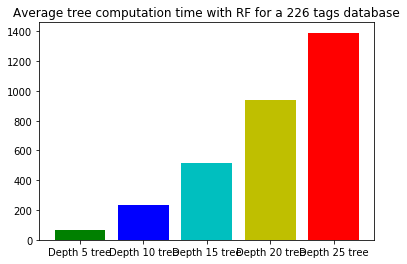

In [152]:
plt.bar(["Depth 5", "Depth 10", "Depth 15", "Depth 20", "Depth 25"], [time_t5, time_t10, time_t15, time_t20, time_t25], color = ['g','b','c','y','r'])
plt.title("Average tree computation time with RF for a 226 tags database")
plt.show()

In [146]:
tree20_times = []
for k in range(20):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t20)
    tree20_times.append(time.time() - t0)
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [147]:
tree25_times = []
for k in range(20):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t25)
    tree25_times.append(time.time() - t0)
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


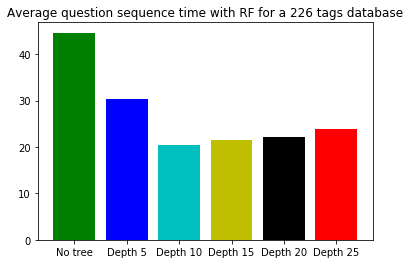

In [151]:
plt.bar(["No tree", "Depth 5", "Depth 10", "Depth 15", "Depth 20", "Depth 25"], [np.mean(notree_times), np.mean(tree5_times), np.mean(tree10_times), np.mean(tree15_times), np.mean(tree20_times), np.mean(tree25_times)], color = ['g','b','c','y','k',"r"])
plt.title("Average question sequence time with RF for a 226 tags database")
plt.show()